In [7]:
import torch

In [8]:
from torch.cuda import get_device_name

name = get_device_name()

print(name)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
# loading the dataset
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

# Transform: convert the dataset + normalize to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5),)
])



In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [5]:
full_dataset = ConcatDataset([train_dataset, test_dataset])

In [6]:
batch_size = 64
dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

print(f"Total images: {len(full_dataset)}")

Total images: 70000


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Total training images : {len(train_dataset)}")

Total training images : 60000


In [24]:
import matplotlib.pyplot as plt

# Get one batch of images and labels
images, labels = next(iter(dataloader))


NameError: name 'dataloader' is not defined

In [9]:
images = images * 0.5 + 0.5  # Since we normalized earlier with mean=0.5, std=0.5


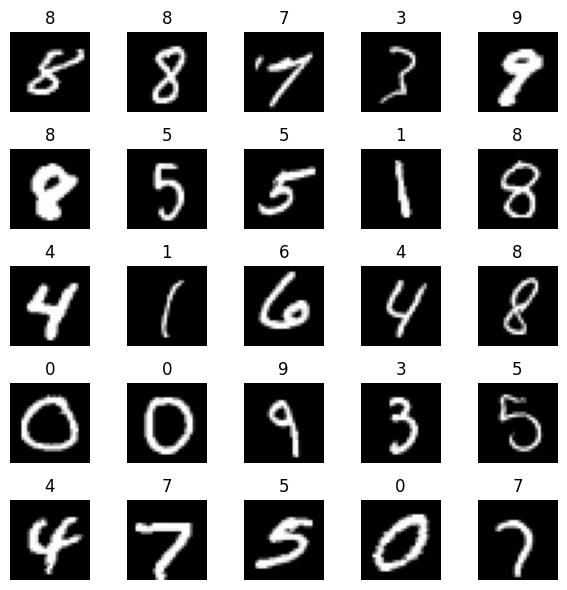

In [10]:
# Plot first 25 images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i][0], cmap='gray')  # [0] to drop the channel dim (1, 28, 28) → (28, 28)
    plt.title(f'{labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [19]:
import numpy as np

# Number of steps in the diffusion process
T = 1000

# Linear noise schedule from 1e-4 to 0.02
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)


In [20]:
# Precalculate alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)   # product of alphas over time

In [21]:
# These are useful for the closed-form noise sampling
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)

In [22]:
def forward_diffusion_sample(x_0, t, device=device):
    """
    Takes an image and a timestampt t
    returns the noised version x_t and the noise used
    """
    # Ensure x_0 is on the correct device
    # x_0 = x_0.to(device)
    
    # # Ensure t is on the correct device
    # t = t.to(device)
    
    # Generate noise on the correct device
    noise = torch.randn_like(x_0).to(device)
    
    # Get the noise schedule values and ensure they're on the correct device
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t][:, None, None, None].to(device)  # Fixed the indexing
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t][:, None, None, None].to(device)  # Fixed the indexing

    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

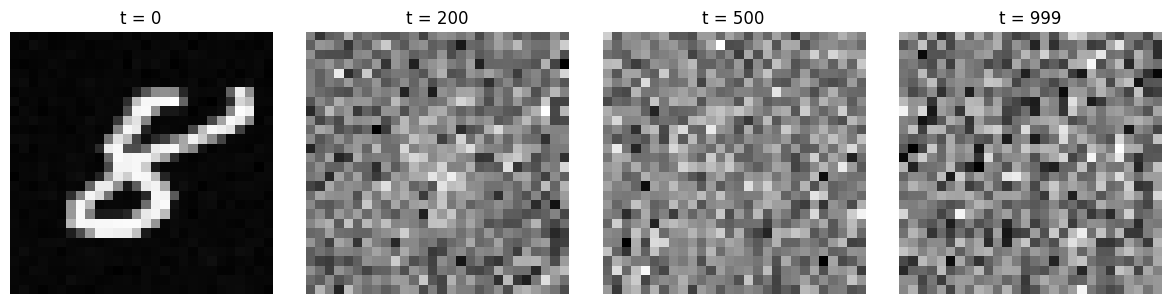

In [15]:
# Picking the first image from the dataset
image = images[0].unsqueeze(0).to(device)  

# picking some random timesteps to visualize how the diffusion process looks like
timesteps = torch.tensor([0, 200, 500, 999]).to(device)

plt.figure(figsize=(12, 3))
for idx, t in enumerate(timesteps):
    t_batch = torch.tensor([t])
    noisy_image, _ = forward_diffusion_sample(image, t_batch)
    noisy_image = noisy_image.squeeze().detach().cpu().numpy()
    
    plt.subplot(1, 4, idx + 1)
    plt.imshow(noisy_image, cmap='gray')
    plt.title(f"t = {t.item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [3]:
import math
import torch.nn as nn

# Positional embedding which basically tells the UNet model 'at which position we at'
# It is used for the model to understand what a timestep exactly means and understand how close we are at from pure noise
# Nearby 't' have some sort of relation, that the x(t-1) is the previous step to x(t)
# If t=999, we are very far from diffusion and if t=10, we are close to recreating the original image
class SinusodialTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        # t: (batch,)
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:,None] * emb[None,:]   # shape (batch, half_dim)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb

In [4]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = x
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x += self.shortcut(identity)
        return F.relu(x)

class EnhancedUNet(nn.Module):
    def __init__(self, time_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusodialTimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU(),
            nn.Linear(time_dim, time_dim)
        )

        # Encoder
        self.enc1 = ResidualBlock(1, 64)
        self.enc2 = ResidualBlock(64, 128)
        self.enc3 = ResidualBlock(128, 256)

        # Time projections
        self.time_proj1 = nn.Linear(time_dim, 64)
        self.time_proj2 = nn.Linear(time_dim, 128)
        self.time_proj3 = nn.Linear(time_dim, 256)

        # Bottleneck
        self.bottleneck = ResidualBlock(256, 256)

        # Decoder
        self.dec1 = ResidualBlock(512, 128)  # 256 + 256 from skip
        self.dec2 = ResidualBlock(256, 64)   # 128 + 128 from skip
        self.dec3 = nn.Conv2d(128, 1, 3, padding=1)  # 64 + 64 from skip

    def forward(self, x, t):
        t_emb = self.time_mlp(t)

        # Encoder
        x1 = self.enc1(x) + self.time_proj1(t_emb).view(-1, 64, 1, 1)
        x2 = self.enc2(x1) + self.time_proj2(t_emb).view(-1, 128, 1, 1)
        x3 = self.enc3(x2) + self.time_proj3(t_emb).view(-1, 256, 1, 1)

        # Bottleneck
        x = self.bottleneck(x3)

        # Decoder with skip connections
        x = self.dec1(torch.cat([x, x3], dim=1))
        x = self.dec2(torch.cat([x, x2], dim=1))
        x = self.dec3(torch.cat([x, x1], dim=1))

        return x

In [9]:
model = EnhancedUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
mse = nn.MSELoss()

In [12]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [19]:
total_params = 0
for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    params = parameter.numel()
    total_params+=params

print(f"Total Trainable Params: {total_params}")

Total Trainable Params: 3617857


In [20]:
# PSNR function to evaluate the model performance
# this helps us check whether the generated image actually makes sense or is some random noise
def psnr(pred, target, max_val=1.0):
    mse = F.mse_loss(pred, target, reduction='mean')
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse))


Average Loss: 0.021091 | Average PSNR: 7.59
Checkpoint saved at epoch 200


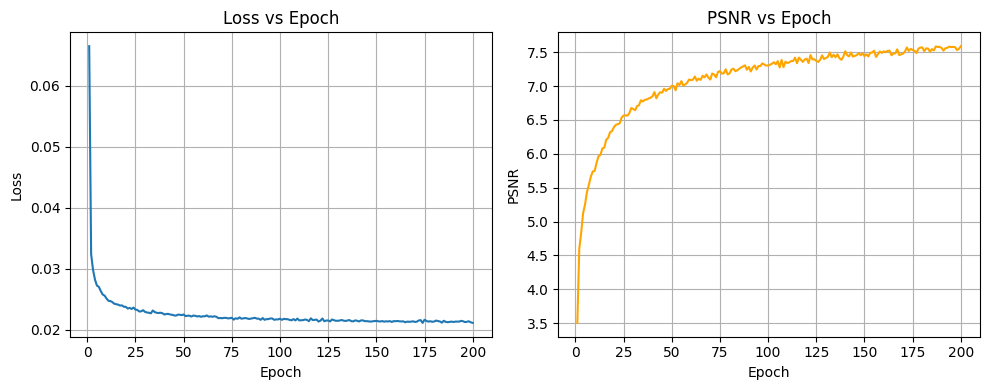

In [21]:
import torch
import tqdm
import os
from IPython.display import clear_output

epochs = 200
start_epoch = 0  # Will be updated if loading from checkpoint

# Load checkpoint if it exists
checkpoint_path = "checkpoint.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    losses_per_epoch = checkpoint['losses_per_epoch']
    psnrs_per_epoch = checkpoint['psnrs_per_epoch']
    print(f"Resumed training from epoch {start_epoch}")
else:
    losses_per_epoch = []
    psnrs_per_epoch = []

print("Starting training...")
for epoch in range(start_epoch, epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    pbar = tqdm.tqdm(dataloader)

    total_loss = 0
    step_count = 0
    total_psnr = 0

    for step, (x, _) in enumerate(pbar):
        x = x.to('cuda:0')
        batch_size = x.shape[0]

        t = torch.randint(0, T, (batch_size,), device='cuda:0').long()
        x_t, noise = forward_diffusion_sample(x, t)
        noise_pred = model(x_t, t)

        loss = mse(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        alpha_bar = sqrt_alphas_cumprod[t][:, None, None, None]
        one_minus_alpha_bar = sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        x0_pred = (x_t - one_minus_alpha_bar * noise_pred) / alpha_bar
        x0_pred = torch.clamp(x0_pred, -1, 1)

        batch_psnr = psnr(x0_pred, x)

        total_loss += loss.item()
        total_psnr += batch_psnr.item()
        step_count += 1

        pbar.set_description(f"Loss: {loss.item():.4f} | PSNR: {batch_psnr.item():.2f}")

    clear_output(wait=True)
    avg_loss = total_loss / step_count
    avg_psnr = total_psnr / step_count

    losses_per_epoch.append(avg_loss)
    psnrs_per_epoch.append(avg_psnr)

    print(f"Average Loss: {avg_loss:.6f} | Average PSNR: {avg_psnr:.2f}")

    # Save checkpoint after each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses_per_epoch': losses_per_epoch,
        'psnrs_per_epoch': psnrs_per_epoch,
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")

    # Plot every epoch
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), losses_per_epoch, label='MSE Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), psnrs_per_epoch, label='PSNR (dB)', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("PSNR")
    plt.title("PSNR vs Epoch")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [17]:
@torch.no_grad()
def sample(model, n_samples, img_size=28, channels=1):
    model.eval()
    x = torch.randn((n_samples, channels, img_size, img_size)).to(device)

    for t in reversed(range(1, T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)

        beta_t = betas[t].to(device)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)
        sqrt_recip_alpha_t = (1.0 / torch.sqrt(alphas[t])).to(device)

        # Predict the noise
        epsilon_theta = model(x, t_batch)

        # Predict x_0
        model_mean = sqrt_recip_alpha_t * (x - beta_t / sqrt_one_minus_alphas_cumprod_t * epsilon_theta)

        # No noise added if t==1 (final step)
        if t > 1:
            noise = torch.randn_like(x).to(device)
            sigma_t = torch.sqrt(beta_t)
            x = model_mean + sigma_t * noise
        else:
            x = model_mean

    x = torch.clamp(x, -1, 1)  # Ensure pixel values are in [-1, 1]
    return x

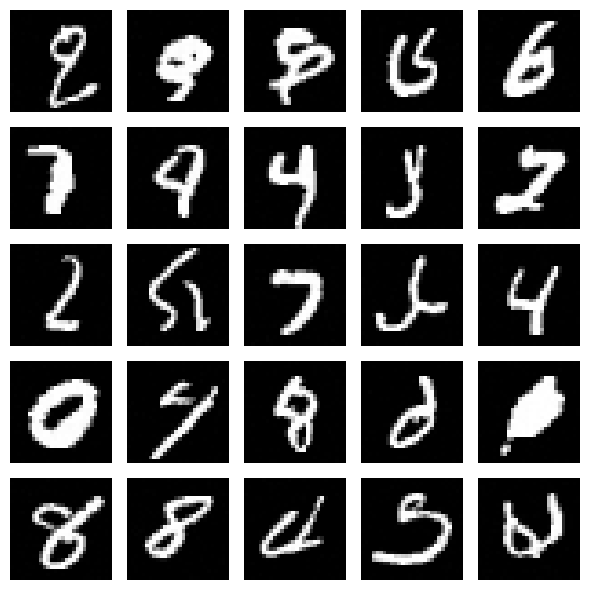

In [26]:
# Visualizing the generated images
samples = sample(model, n_samples=25)

# Unnormalize the images
samples = samples * 0.5 + 0.5  # Since we normalized earlier

# Plot the generated samples
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(samples[i][0].detach().cpu().numpy(), cmap='gray')  # [0] to drop the channel dim (1, 28, 28) → (28, 28)
    plt.axis('off')
plt.tight_layout()
plt.show()
